## Anisotropic Fast Marching Methods ##
Experimenting with finding the shortest path through an anisotropic medium.

Papers being referenced: 
- https://hal.archives-ouvertes.fr/hal-01778322/document
- https://hal.archives-ouvertes.fr/hal-01507334v4/document

GitHub repository with source algorithm: 
- https://github.com/Mirebeau/AdaptiveGridDiscretizations

Demo Jupyter Notebooks:
- https://nbviewer.jupyter.org/github/Mirebeau/AdaptiveGridDiscretizations/blob/master/Notebooks_FMM/Riemannian.ipynb



### Setup ###
First install the necessary packages.<br>
Clone the AGD repository from GitHub, then create an environment using the environment file: <br>
`conda env create --file agd-hfm.yaml` <br>
    
Or install directly with conda: <br>
`conda install agd -c agd-lbr`


In [2]:
import agd
from agd import Eikonal
from agd.Plotting import quiver
import sys
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mayavi import mlab # Plots implicit surfaces in 3D
%matplotlib inline

In [3]:
def crop2topo(grid, dem, a=None):
    '''Crop gempy lith_block to land surface using an imported DEM raster file.
    
    Inputs:
    grid:   list [xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres]
    dem:    array of elevation values, of same xy dimensions as model, to be used for cropping.
    a:      optional: array to be cropped if not using gempy (e.g. as provided by mapping.crop2raster())
            must already be of dimensions (xres,yres,zres)
              
    Output:
    gcrop:    cropped lith_block array'''

    #Get coordinate info from grid & create VTK cells info in coord system instead of in cell indices:
    xmin = grid[0]   #min (left) coordinate
    xmax = grid[1]   #max (right) coordinate
    xres = grid[2]   #number of pixels
    ymin = grid[3]
    ymax = grid[4]
    yres = grid[5]
    zmin = grid[6]   #important: need zmin of model, NOT just DEM: model may extend below lowest point at land surface
    zmax = grid[7]
    zres = grid[8]
        
    dx   = (xmax-xmin)/xres                       #pixel width
    xvals = np.arange(xmin,xmax+dx,dx)            #coordinates of column edges (borders between pixels)
    dy   = (ymax-ymin)/yres
    yvals = np.arange(ymin,ymax+dy,dy)
    dz   = (zmax-zmin)/zres
    zvals = np.arange(zmin,zmax+dz,dz)

    #Get DEM & convert to topo array:
    dema = dem
    dema = dema.astype(float)    #convert integer array to float array
    dema[dema==0] = np.nan       #replace zeros with NaNs (must first convert array to float)        
    t = dema.copy()              #make a copy of elevation values directly from dem (do not use topo grid - different indexing!)
    #t = np.rot90(t)              #rotate & flip to be same orientation as lith block
    #t = np.fliplr(t)                 
    #t = np.flipud(t)

    #Get lith array:
    g = a.copy()                         #if array already provided, use array (make copy) (must already be 3D)
    g = g.round()                            #round to integers

    #Check dimensions for debugging:
    #print('topo shape:\t', t.shape)
    #print('lith shape:\t', g.shape)
    #print('topo min:\t',   t.min(), np.unravel_index(t.argmin(), t.shape)) #show indices of min/max of topography
    #print('topo max:\t',   t.max(), np.unravel_index(t.argmax(), t.shape))
    #print('model min:\t',  zmin) #show min/max of entire model
    #print('model max:\t',  zmax)

    #Get z indices of land surface:
    #ind = sol.grid.topography._find_indices().copy()  #this has the wrong dimensions! do not use! it is stretched to rotate 90 degrees. instead:
    ind = (t - zmin) / dz              #calculate the cell index of each point in the dem array using the cell height (i.e. how many cells/layers up it is from the base)
    #ind = ind - 1                      #bump down by one to represent bottom of cell (this cuts lower than actual topo) 
    ind[ind==-1] = 0                   #zeros should stay zeros and not go negative
    ind = np.ceil(ind)                 #round up to nearest integer 
    ind = ind.astype(int)              #convert to integers for use as vertical indices
    #print('ind:\t', ind.shape, type(ind)) #debugging
    #print(np.unique(ind))

    #Crop off everything above the land surface:
    m = np.zeros((xres,yres))  #create array of zeroes of shape (xres,yres)
    gcrop = g.copy()           #make a copy bc need original as reference
    for x in range(xres):      #loop over x,y indices
        for y in range(yres):
            try:
                z = ind[x,y]            #get land surface elev at point (x,y)
                #m[x,y] = g[x,y,z]       #get lith value at land surface at point (x,y) - only if want to return a map
                gcrop[x,y,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
            except:
                z = ind[y,x]
                gcrop[y,x,z:] = np.nan  #convert all lith values above land surface at point (x,y) to nans
    #print('map:\t', m.shape)       #for debugging
    #print('crop:\t', gcrop.shape)
    
    return gcrop


### Isotropic Fast Marching example ###
Simple explanation here: https://math.berkeley.edu/~sethian/2006/Explanations/fast_marching_explain.html

**Note:** This does not seem to work in 3D

Seed grid indices rounded to [[54 40 42]], with rounding errors [[ 0.5 -0.5 -0.5]]
Rounded positions [[54.5 40.5 42.5]], original positions [[55. 40. 42.]]


dictIn({'arrayOrdering': 'RowMajor', 'model': 'Isotropic3', 'order': 2.0, 'cost': array(1.), 'gridScales': array([1., 1., 1.]), 'dims': array([100.,  80.,  60.]), 'origin': array([0., 0., 0.]), 'seeds': array([[55., 40., 42.]]), 'seedValues': array([0.]), 'exportValues': 1.0, 'exportGeodesicFlow': 1})

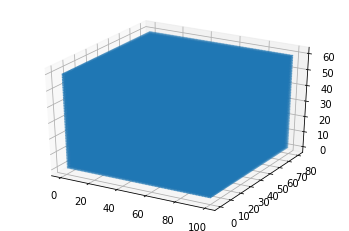

In [4]:
#Create input object:
hfmIn = Eikonal.dictIn({   # Create a dictionary-like structure to store the input data
    'model': 'Isotropic3', # Isotropic eikonal equation (use Isotropic2 for 2D, Isotropic3 for 3D)
    'order':  2.,          # Use a second order scheme, so as to increase accuracy
    'cost':   1.           # Unit cost for now. A position dependent cost function is also considered below.
    #'speed': 1.           # One may equivalently provide a speed function. In that case cost = 1/speed.
})

#Create grid:
xmin = 0;  xmax = 100;  xres = 100;  dx = 1.0 
ymin = 0;  ymax = 80;   yres = 80;   dy = 1.0 
zmin = 0;  zmax = 60;   zres = 60;   dz = 1.0
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]], dims=[xres,yres,zres])  #create a grid with sides [xmin,xmax],[ymin,ymax] and dims (height/gridScale, width/gridScale)
X,Y,Z = hfmIn.Grid()                                  #create a coordinate system (two arrays of the X and Y values (respectively) at each point in the grid)
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, s=0.5)                               #visualize the grid

#Define the target points (the seeds, at which travel time = 0):
hfmIn.update({
    'seeds':[[55, 40, 42]],  # Introduce seeds, at positions [[x1,y1],[x2,y2],...] (will be rounded to closest grid point)
    'seedValues':[0.],           # Boundary conditions imposed at the seeds. (?)
    # 'seedValues' defaults [0.] if unspecified. 
})
index,rounding_error = hfmIn.IndexFromPoint(hfmIn['seeds'])  #get rounded indices of seeds in grid
print(f"Seed grid indices rounded to {index}, with rounding errors {rounding_error}")
print(f"Rounded positions {hfmIn.PointFromIndex(index)}, original positions {hfmIn.PointFromIndex(index+rounding_error)}") #get back original positions if needed

#Indicate desired outputs:
hfmIn['exportValues'] = 1.         # Ask for the PDE solution
hfmIn['exportGeodesicFlow'] = 1    # Ask for the geodesic flow 
hfmIn

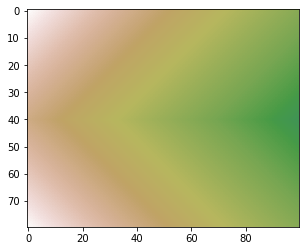

In [5]:
#Create topography array:
dema = np.full((yres,xres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.25                      #set the slope in the x direction (west to east)
my = -0.25                      #set the slope in the y direction (north to south)
valley  = yres//2               #set which row to put the valley in
for col in range(xres):                 #move west to east along columns
    dema[:,col] = mx*col + dema[0,0]    #change the elevation in each column along a slope, starting from the max elevation
    for row in range(0,valley+1):       #move down rows towards valley (north to south)
        dema[row,col] = my*row + dema[0,col]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for row in range(valley,yres):                 #move down rows away from valley (south to north)
    dema[row,:] = dema[yres-row,:]             #insert a mirror image of the north side of the valley
plt.imshow(dema, vmin=zmin, vmax=zmax, cmap='gist_earth')

In [6]:
hfmIn.PointFromIndex([ispring[0],ispring[1],ispring[2]])

NameError: name 'ispring' is not defined

In [ ]:
#Create topography array:
dema = np.full((yres,xres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.25                      #set the slope in the x direction (west to east)
my = -0.25                      #set the slope in the y direction (north to south)
valley  = yres//2               #set which row to put the valley in
for col in range(xres):                 #move west to east along columns
    dema[:,col] = mx*col + dema[0,0]    #change the elevation in each column along a slope, starting from the max elevation
    for row in range(0,valley+1):       #move down rows towards valley (north to south)
        dema[row,col] = my*row + dema[0,col]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for row in range(valley,yres):                 #move down rows away from valley (south to north)
    dema[row,:] = dema[yres-row,:]             #insert a mirror image of the north side of the valley
f = plt.figure(figsize=(15,5))
f.add_subplot(151)
plt.imshow(dema, vmin=zmin, vmax=zmax, cmap='gist_earth')

#Convert from elevations to z cell indices:
idem = np.empty((yres,xres), dtype=int)    
for row in range(yres):
    for col,z in enumerate(dema[row,:]):
        [[yind,xind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        idem[row,col] = zind-1 #correct to be index below
f.add_subplot(152)
plt.imshow(idem, vmin=zmin, vmax=zmax, cmap='gist_gray') #0=bottom,black, 1=top,white
print(np.unique(idem))

#Create geologic contact surface elevation array:
zstart = zmax - (zmax-zmin)//4
zcontact = np.full((yres,xres), zstart, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.1                      #set the slope in the x direction (west to east)
my = -0.1                      #set the slope in the y direction (north to south)
valley  = yres//2              #set which row to put the valley in
for col in range(xres):               #move west to east along columns
    zcontact[:,col] = mx*col + zcontact[0,0]    #change the elevation in each column along a slope, starting from the max elevation
    for row in range(ymin,valley+1):  #move down rows towards valley (north to south)
        zcontact[row,col] = my*row + zcontact[0,col]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for row in range(valley,yres):        #move down rows away from valley (south to north)
    zcontact[row,:] = zcontact[yres-row,:]            #insert a mirror image of the north side of the valley
f.add_subplot(153)
plt.imshow(zcontact, vmin=zmin, vmax=zmax, cmap='gist_earth')

#Convert from elevations to cell z indices:
icontact = np.empty((yres,xres))
#for row in range(yres):
    #_,_,icontact[row,:] = mapping.xyz2rowcollay([],[], zcontact[row,:], [xres,yres,zres,xmin,ymin,zmin,xmax,ymax,zmax])
for row in range(yres):
    for col,z in enumerate(zcontact[row,:]):
        [[yind,xind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        icontact[row,col] = zind - 1
f.add_subplot(154)
plt.imshow(icontact, vmin=zmin, vmax=zmax, cmap='gist_gray')

#Create 3D geology array (the integer in each cell indicates the formation present in that cell):
#Important: layer 0 is at the top, layer 60 is at the bottom (NOT vice-versa)
geo = np.empty((yres,xres,zres))   #set empty 3D array of model dimensions
for col in range(xres):            #loop over cols, rows, & layers
    for row in range(yres):
        for lay in range(zres):             #for each cell, 
            if lay <= icontact[row,col]:    #if layer is below the contact index (i.e. has a lower index),
                geo[row,col,lay] = 2        #assign 2 for shale
            if lay > icontact[row,col]:     #if layer is above the contact index (i.e. has a higher index),
                geo[row,col,lay] = 1        #assign 1 for limestone

#Create geologic map
geomap = np.empty((yres,xres))      #set empty 2D array of model dimensions
for col in range(xres):             #loop over cols, rows
    for row in range(yres):
        lay = idem[row,col]                 #get layer index of land surface at current cell
        geomap[row,col] = geo[row,col,lay]  #assign map value to be geologic formation present at current cell at land surface
f.add_subplot(155)
cmap = matplotlib.colors.ListedColormap(['lightgray','yellowgreen','saddlebrown']) #create custom colormap
plt.imshow(geomap, cmap=cmap, vmin=0, vmax=2)                 #0:nan, gray, 1: limestone, green 2: shale, brown  

#Define spring:
ispring = [55,40]            #col, row
#_,_,zspring = mapping.xyz2rowcollay([], [], [dema[55,40]], [xres,yres,zres,xmin,ymin,zmin,xmax,ymax,zmax])  #get layer index
[[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,dema[55,40]])
zspring = zind - 1
ispring.append(int(zspring))
#springXYZ = mapping.xyz2rowcollay([ispring[0]], [ispring[1]], [ispring[2]], [xres,yres,zres,xmin,ymin,zmin,xmax,ymax,zmax], flip=True) #get coordinates based on indices
springXYZ = hfmIn.PointFromIndex([ispring[0],ispring[1],ispring[2]])
#springXYZ = [item[0] for item in springXYZ]  #flatten list
plt.scatter(ispring[0], ispring[1], s=20)    #show spring location
print(ispring, springXYZ)

#Crop:
lithZcrop  = crop2topo([xmin,xmax,xres, ymin,ymax,yres, zmin,zmax,zres], dema, geo)   #crop to land surface (only works if the xy resolution of the DEM is the same as the xy resolution of the model)

In [ ]:
#Generate starting points for walkers:
ntips = 5  
tips = []
for i in range(ntips):                   #generate random starting points
    x = random.randrange(xmin,int(springXYZ[1]),dx) - dx/2   #get random integer and move to center of cell
    y = random.randrange(ymin,ymax,dy) - dy/2
    [[col,row,lay],trash] = hfmIn.IndexFromPoint([x,y,0])
    #print('x,y:',x,y)
    #print('col,row,lay:',col,row,lay)
    z = dema[row,col]                  #extract surface elevation
    tip = [x,y,z]                        #for 3d, tip = [x,y,z]        
    tips.append(tip)
    #print('tip:', tip)
hfmIn['tips'] = tips # Ask for the geodesics from specified points (these are the points where walkers would start from to reach the seeds)


In [7]:
# Run the solver:
#hfmIn['stopWhenAllAccepted']=hfmIn['tips'] # Abort computation when all the tips are reached by the front
hfmOut = hfmIn.Run()
print("Output keys : ", hfmOut.keys(),"\n")  #view keys for getting outputs

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.518 s.
Output keys :  dict_keys(['FMCPUTime', 'GeodesicCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'flow', 'nAccepted', 'unusedFromCompute', 'values', 'visitedUnset']) 



KeyError: 'tips'

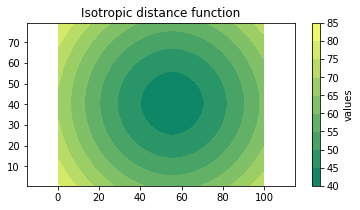

In [8]:
#Plot a contour map of travel times to the seeds (t=0 at the seed):
f = plt.figure(figsize=[6,3]); plt.title('Isotropic distance function'); plt.axis('equal');
z = 0
v = plt.contourf(X[:,:,z],Y[:,:,z],hfmOut['values'][:,:,z], cmap='summer'); # Display the value function at a specified z location
cbar = f.colorbar(v)
cbar.ax.set_ylabel('values')

#Plot seeds & tips:
seedX = hfmIn['seeds'][:,0]         #get seed & tip coordinates
seedY = hfmIn['seeds'][:,1]
tipX = hfmIn['tips'][:,0]
tipY = hfmIn['tips'][:,1]
plt.scatter(seedX,seedY, c='c')    #plot seed points
plt.scatter(tipX,tipY,   c='k')    #plot origin point
for i in range(len(seedX)):
    plt.annotate('seed',(seedX[i],seedY[i]))  #label points
for i in range(len(tipX)):
    plt.annotate('tip',(tipX[i],tipY[i]))     #label points

# Draw the geodesics (the shortest path from tip to seed)
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(pathX,pathY,c='k')   #plot as lines



In [55]:
#Plot in 3D:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
mlab.contour3d(hfmOut['values'], contours=contours)
mlab.show() # Displays in an external window. 

**Introduce position-dependent cost:**

Some locations are easier to move through than others (ex: limestone vs. shale)

Text(0, 0.5, 'cost')

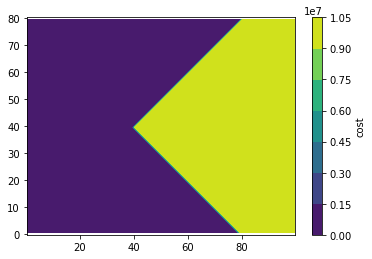

In [93]:
#Define cost function & view:
#0: nan, 1: limestone 2: shale  
#higher cost = slower to travel through
cost = np.rot90(lithZcrop, axes=[1,0])
cost[np.isnan(cost)] = 999  #assign very high cost to areas outside model boundary
cost[cost==1] = 1        #assign low cost to limestone
cost[cost==2] = 100       #assign higher cost to shale
hfmIn['cost'] =  cost  #cost is an array of dim(xres,yres) with the value in each cell indicating how difficult it is to move through that cell (higher value=harder to move)
f = plt.figure()
z = 40
v = plt.contourf(X[:,:,z],Y[:,:,z],hfmIn['cost'][:,:,z])
plt.axis('equal')
cbar = f.colorbar(v)
cbar.ax.set_ylabel('cost')

In [94]:
#Run:
#hfmIn['stopWhenAllAccepted']=hfmIn['tips'] # Abort computation when all the tips are reached by the front
hfmOut =hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.612 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


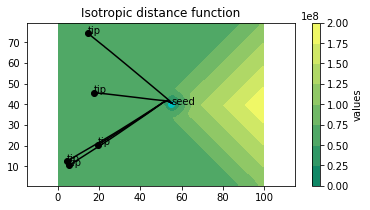

In [95]:
#View output:
#Plot a contour map of travel times to the seeds (t=0 at the seed):
f = plt.figure(figsize=[6,3]); plt.title('Isotropic distance function'); plt.axis('equal');
z = 40
v = plt.contourf(X[:,:,z],Y[:,:,z],hfmOut['values'][:,:,z], cmap='summer'); # Display the value function.
cbar = f.colorbar(v)
cbar.ax.set_ylabel('values')

#Plot seeds & tips:
seedX = hfmIn['seeds'][:,0]         #get seed & tip coordinates
seedY = hfmIn['seeds'][:,1]
tipX = hfmIn['tips'][:,0]
tipY = hfmIn['tips'][:,1]
plt.scatter(seedX,seedY, c='c')    #plot seed points
plt.scatter(tipX,tipY,   c='k')    #plot origin point
for i in range(len(seedX)):
    plt.annotate('seed',(seedX[i],seedY[i]))  #label points
for i in range(len(tipX)):
    plt.annotate('tip',(tipX[i],tipY[i]))     #label points

# Draw the geodesics (the shortest path from tip to seed)
for path in hfmOut['geodesics']:  #loop over paths (one per tip/starting point)
    pathX = path[0,:]             #get list of X coord
    pathY = path[1,:]
    plt.plot(pathX,pathY,c='k')   #plot as lines


In [96]:
#Plot in 3D:
contours = np.linspace(np.min(hfmOut['values']), np.max(hfmOut['values']), num=10).tolist() #generate contours
mlab.contour3d(hfmOut['values'], contours=contours)
mlab.show() # Displays in an external window. 